# Классификация текстов с использованием Наивного Байесовского Классификатора

## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# запишем наши данные в датасет
data = pd.read_csv('spam_or_not_spam.csv')
data.head(3)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0


In [3]:
# рассчитайте частоты для классов : ваш код здесь
data['label'].value_counts()

label
0    2500
1     500
Name: count, dtype: int64

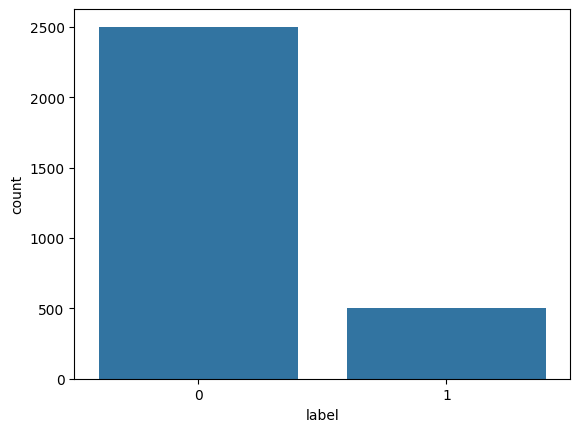

In [4]:
# визуализируйте результат: ваш код здесь
sns.barplot(data['label'].value_counts());


И так, у нас наблюдается несбалансированность данных:
- 2500 у нас не спам сообщений
- 500 спам сообщений.

## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [6]:
#ваш код здесь
data['email']=data['email'].replace(' ',np.nan)
data=data.dropna(axis=0)

Переводим данные в векторный вид:

In [7]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data["email"])

Определите, сколько теперь признаков в нашем наборе данных:

In [8]:
#ваш код здесь
print(f'количество признаков, после преобразования равно {X.shape[1]}')

количество признаков, после преобразования равно 34116


## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [9]:
#ваш код здесь
X = X.copy()
y = data['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [10]:
#ваш код здесь
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,train_size=0.75,stratify=y,random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [11]:
#ваш код здесь
print(f'Среднее значение по целевой переменой в тестовой выборке: {y_test.mean().round(3)}')

Среднее значение по целевой переменой в тестовой выборке: 0.165


## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [46]:
#ваш код здесь
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
model = ComplementNB(alpha=0.01)
model.fit(X_train,y_train)

ComplementNB(alpha=0.01)

Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [47]:
#ваш код здесь
y_predict = model.predict(X_test)
print('accuracy_score:', round(accuracy_score(y_test,y_predict),3))
print('precision_score:', round(precision_score(y_test,y_predict),3))
print('recall_score:', round(recall_score(y_test,y_predict),3))
print('f1_score:',round(f1_score(y_test,y_predict),3))

accuracy_score: 0.988
precision_score: 1.0
recall_score: 0.927
f1_score: 0.962


Нарисуйте ROC-кривую:

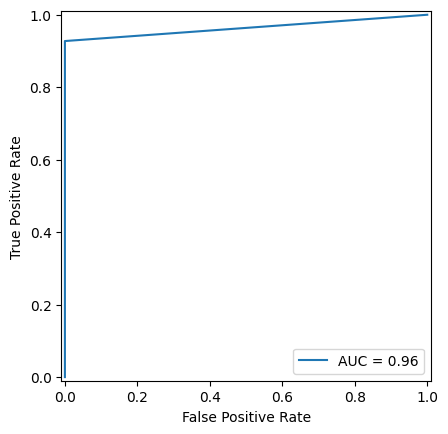

In [57]:
#ваш код здесь
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test,y_predict )
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

In [ ]:
#ваш код здесь
from sklearn.model_selection import GridSearchCV 
# Создаем сетку с нашими гиперпараметрами и их значениями, в данном случае мы изменяем только параметр alpha
grid = {"alpha": (np.linspace(0, 1, 11,endpoint=True)).round(3)}
# Создаем новую модель
model_GD = ComplementNB()
# Модель поиска гиперпараметров
GD=GridSearchCV(estimator=model_GD,
                param_grid=grid,
                n_jobs=-1,
                cv=5,
                scoring='f1')
# Обучаем ее на тренировочных данных
GD.fit(X_train, y_train) 

In [124]:
print('средняя метрика на кросс-валидации:', GD.best_score_)
print('Наилучшие гиперпараметры:', GD.best_params_)
# Делаем предсказание 
y_test_pred = GD.predict(X_test)
print(metrics.f1_score(y_test, y_test_pred))


средняя метрика на кросс-валидации: 0.9744937463505361
Наилучшие гиперпараметры: {'alpha': np.float64(0.4)}
0.983739837398374


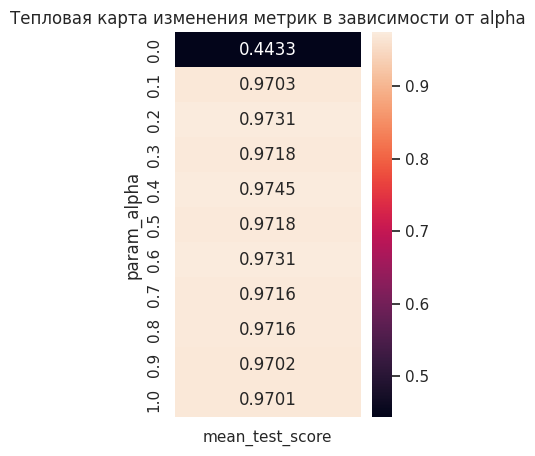

In [125]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(GD.cv_results_),
                        values='mean_test_score', index='param_alpha')
sns.heatmap(visual,annot=True,fmt=".4g")
plt.title('Тепловая карта изменения метрик в зависимости от alpha') # подпись графика
sns.set(rc={'figure.figsize':(3, 5)}) #задаем размер графика

In [126]:
print('accuracy_score:', round(accuracy_score(y_test,y_test_pred ),3))
print('precision_score:', round(precision_score(y_test,y_test_pred ),3))
print('recall_score:', round(recall_score(y_test,y_test_pred ),3))
print('f1_score:',round(f1_score(y_test,y_test_pred ),3))

accuracy_score: 0.995
precision_score: 0.992
recall_score: 0.976
f1_score: 0.984


В итоге мы получили немного улучшенные метрики, когда изменили наш гиперпараметр alpha.